# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.tree import export_graphviz


# Open CSV

In [2]:
opps = pd.read_csv("../data/concat_data.csv")

drop_col = opps.columns[0]

if "unnamed" in drop_col.lower():
    opps = opps.drop(drop_col, 1)



* * *

### Save Features before changes


In [3]:
save_features = {
                    "Opportunity ID" : None,
                    "Account ID" : None, 
                    "Building ID" : None,
                    "Latitude" : None,
                    "Longitude" : None
                }

for save_feature in save_features.keys():
    save_series = opps[save_feature]
    save_features[save_feature] = save_series

## Encode String data to ints

In [4]:
column_names = list(opps.columns)

encode_dict = {}
decode_dict = {}

# Encode string values to int values
for column_name in column_names:
    dtype = opps[column_name].dtype
    if dtype == object:
        
        if column_name == "StageName" or column_name in save_features:
            continue
            
        current_series = opps[column_name]
        current_encode_dict = { key : int(index) for index, key in enumerate(current_series.unique())}
        current_decode_dict = { int(index) : key  for index, key in enumerate(current_series.unique())}

        
        new_series = pd.Series([current_encode_dict[val] for val in current_series])
        opps[column_name] = new_series
        encode_dict[column_name] = current_encode_dict
        decode_dict[column_name] = current_decode_dict

opps.fillna(value=0)

opps.head(3)


,Opportunity ID,Account ID,StageName,IsClosed,IsWon,CreatedDate,Term in Months,Service,Opportunity Type,Product Group,...,X36 NRR List,Latitude,Type,Longitude,Net Classification,DandB Total Employees,AnnualRevenue,Estimated Build Cost,X36 MRC List,Total BRR
0,Opp-000001,Acct-000007,Closed - Lost,True,False,0,12.0,0,0,0,...,1073.717164,33.755431,0,-84.391561,0,0.0,0.0,11993.5,1775.345373,1334080.00
1,Opp-000002,Acct-000986,5 - Accepted,True,True,0,60.0,0,0,1,...,4610.000000,34.035421,1,-84.060881,0,0.0,0.0,21243.7,3163.050000,2910.34
2,Opp-000002,Acct-000986,5 - Accepted,True,True,0,60.0,0,0,1,...,4610.000000,34.036374,2,-84.063305,1,0.0,0.0,17522.2,3163.050000,2910.34


# Feature Engineering

Let's see what we're working with (the opps dataframe!)

In [5]:
opps.columns

Index(['Opportunity ID', 'Account ID', 'StageName', 'IsClosed', 'IsWon',
       'CreatedDate', 'Term in Months', 'Service', 'Opportunity Type',
       'Product Group', 'Building ID', 'Market', 'Street Address', 'City',
       'State', 'Postal Code', 'Network Proximity', 'On Zayo Network Status',
       'NumberOfEmployees', 'Vertical', 'X36 NPV List', 'Industry',
       'X36 NRR List', 'Latitude', 'Type', 'Longitude', 'Net Classification',
       'DandB Total Employees', 'AnnualRevenue', 'Estimated Build Cost',
       'X36 MRC List', 'Total BRR'],
      dtype='object')

### Dropped Features
- Opportunity ID
- Account ID
- IsClosed
- IsWon
- CreatedDate
- Building ID
- Street Address
- Longitude
- Latitude
- Service

In [6]:
drop_features = ["IsClosed", "IsWon", "CreatedDate", "Street Address", "Longitude", "Latitude", "Opportunity ID", "Account ID", "Building ID", "Service"]

saved_features_df = opps[drop_features].copy()

opps_dropped = opps.copy(deep=True)
for drop_feature in drop_features:
    opps_dropped = opps_dropped.drop(drop_feature, 1)


#### Confirm Columns are Dropped

In [7]:
drop_success = True
for drop_feature in drop_features:
    if drop_feature in opps_dropped.columns:
        drop_success = False
        break
        
print("Drop {}!".format("Successful" if drop_success else "Unsuccessful"))

Drop Successful!


### Aggregate Features

StageName 

In [8]:
# Define stage_names series
stage_names = opps_dropped["StageName"]

# Define sorting for stage names
stage_name_sorter = {    
                        "Closed - Lost" : 0, 
                        "1 - Working" : -1, 
                        "2 - Best Case" : -1, 
                        "3 - Committed" : 1, 
                        "4 - Closed" : 1, 
                        "5 - Accepted" : 1
                    }

# Loop through stage names and sort
clf_data = []
clf_unlabeled_data = []
clf_unlabeled_data_id_dict = {}

for save_feature in save_features:
    clf_unlabeled_data_id_dict[save_feature] = []

for index, stage_name in enumerate(stage_names):
    classifier = stage_name_sorter[stage_name]
    
    # Save into unlabeled data
    if classifier == -1:
        clf_unlabeled_data.append(list(opps_dropped.loc[index][1:]))
        for save_feature in save_features:
            clf_unlabeled_data_id_dict[save_feature].append(save_features[save_feature][index])
    
    # Save for training data
    else:
        current_data = list(opps_dropped.loc[index][1:])
        current_data.append(classifier)
        clf_data.append(current_data)

### Training Data Dataframe

In [9]:
# Declare column names and remove StageName
column_names = list(opps_dropped.columns)
del column_names[column_names.index("StageName")]

# Add "Y_Label" Column
column_names.append("Y_Label")

# Define the unlabaled data dataframe
clf_data_df = pd.DataFrame(clf_data, columns=column_names)

# Fill NaN values
clf_data_df = clf_data_df.fillna(value=0.0)

clf_data_df.head(3)

,Term in Months,Opportunity Type,Product Group,Market,City,State,Postal Code,Network Proximity,On Zayo Network Status,NumberOfEmployees,...,Industry,X36 NRR List,Type,Net Classification,DandB Total Employees,AnnualRevenue,Estimated Build Cost,X36 MRC List,Total BRR,Y_Label
0,12.0,0,0,0,0,0,30303,66.45,0,0.0,...,0,1073.717164,0,0,0.0,0.0,11993.5,1775.345373,1334080.00,0
1,60.0,0,1,0,1,0,30024,374.79,0,0.0,...,1,4610.000000,1,0,0.0,0.0,21243.7,3163.050000,2910.34,1
2,60.0,0,1,0,1,0,30024,250.74,0,0.0,...,1,4610.000000,2,1,0.0,0.0,17522.2,3163.050000,2910.34,1


### Unlabeled Data Dataframe

In [10]:
# Declare column names and remove StageName
column_names = list(opps_dropped.columns)
del column_names[column_names.index("StageName")]

# Define the unlabaled data dataframe
clf_unlabeled_data_df = pd.DataFrame(clf_unlabeled_data, columns=column_names)

# Fill NaN values
clf_unlabeled_data_df = clf_unlabeled_data_df.fillna(value=0.0)

clf_unlabeled_data_df.head(3)

,Term in Months,Opportunity Type,Product Group,Market,City,State,Postal Code,Network Proximity,On Zayo Network Status,NumberOfEmployees,...,X36 NPV List,Industry,X36 NRR List,Type,Net Classification,DandB Total Employees,AnnualRevenue,Estimated Build Cost,X36 MRC List,Total BRR
0,0.0,0,0,0,0,0,30309,185.76,0,0.0,...,33413.167626,3,1395.266259,1,0,0.0,0.000000e+00,15572.8,2821.670576,0.0
1,0.0,0,2,0,0,0,30309,185.76,0,0.0,...,33413.167626,3,1395.266259,1,0,0.0,0.000000e+00,15572.8,2821.670576,0.0
2,0.0,0,0,0,0,0,30303,66.45,0,116000.0,...,23266.981628,2,1126.085581,0,0,116000.0,1.988192e+11,11993.5,1285.116977,683378.0


# Random Forest

### Setup Classifier

In [11]:
clf = ensemble.RandomForestClassifier()

## Setup Training Data and Fit Classifier

In [12]:
# Sample the clf data
shuffled = clf_data_df.sample(frac=1)

# Setup Features and Prediction columns
features = list(clf_data_df.columns)
del features[features.index("Y_Label")]
features_dict = { val:key for val, key in enumerate(features)}
prediction = "Y_Label"

# Set Fraction of data to take for training
fraction = 9.0/10.0

# Setup the Training data
trainX = shuffled[features][:int(round(fraction*len(shuffled)))].values
trainY = shuffled[prediction][:int(round(fraction*len(shuffled)))].values
trainY = np.reshape(trainY, (len(trainY),))

# Fit the classifier
clf = clf.fit(trainX, trainY)


## Score

In [13]:
testX = shuffled[features][int(round(fraction*len(shuffled))):].values
testY = shuffled[prediction][int(round(fraction*len(shuffled))):].values

print("Training Data Accuracy: {}".format(clf.score(trainX, trainY)))
print("Testing Data Accuracy: {}".format(clf.score(testX, testY)))

Training Data Accuracy: 0.9610274579273693
Testing Data Accuracy: 0.796812749003984


## Create Tree Visualizations

In [15]:
# export_graphviz(clf, out_file="tree.dot", class_names=["Sale", "No Sale"], feature_names=features, impurity=False, filled=True)
# ensemble.export_graphviz(clf, out_file="tree.dot")
for index, tre in enumerate(clf.estimators_, 1):
    export_graphviz(tre, out_file="../trees/tree{}.dot".format(index), class_names=["Sale", "No Sale"], feature_names=features, impurity=False, filled=True)

## Feature Ranking Plot

Feature ranking:
 1. Term in Months                 0.2174
 2. Total BRR                      0.1291
 3. X36 NRR List                   0.0649
 4. X36 NPV List                   0.0605
 5. X36 MRC List                   0.0574
 6. Product Group                  0.0526
 7. Estimated Build Cost           0.0514
 8. Vertical                       0.0456
 9. NumberOfEmployees              0.0429
10. AnnualRevenue                  0.0426
11. Network Proximity              0.0397
12. Postal Code                    0.0353
13. City                           0.0306
14. Type                           0.0284
15. DandB Total Employees          0.0270
16. Industry                       0.0248
17. Opportunity Type               0.0123
18. Net Classification             0.0117
19. State                          0.0102
20. Market                         0.0089
21. On Zayo Network Status         0.0067


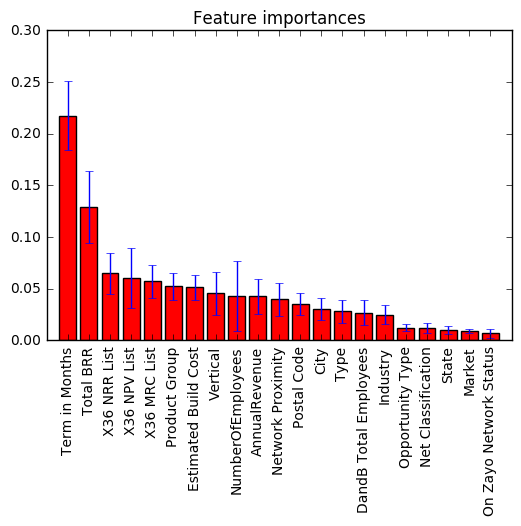

In [16]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
x_labels = [features_dict[val] for val in indices]

for f in range(trainX.shape[1]):
    print("{:2d}. {:30s} {:0.4f}".format(f + 1, x_labels[f], importances[indices[f]]))

    



plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(trainX.shape[1]), x_labels, rotation='vertical')
plt.xlim([-1, trainX.shape[1]])
plt.show()


# Find the Accounts of Interest

In [17]:
clf_unlabeled_data_df.head(2)

,Term in Months,Opportunity Type,Product Group,Market,City,State,Postal Code,Network Proximity,On Zayo Network Status,NumberOfEmployees,...,X36 NPV List,Industry,X36 NRR List,Type,Net Classification,DandB Total Employees,AnnualRevenue,Estimated Build Cost,X36 MRC List,Total BRR
0,0.0,0,0,0,0,0,30309,185.76,0,0.0,...,33413.167626,3,1395.266259,1,0,0.0,0.0,15572.8,2821.670576,0.0
1,0.0,0,2,0,0,0,30309,185.76,0,0.0,...,33413.167626,3,1395.266259,1,0,0.0,0.0,15572.8,2821.670576,0.0


## Get Predictions and make df

In [18]:
# Get predictions
predict_y = clf.predict(clf_unlabeled_data_df)

# Prediction frame
predict_y_df = pd.DataFrame(predict_y, columns=["Prediction"])

## Add back saved features

In [19]:
# Reintroduce saved features
df_concat_list = []
for save_feature_id, feat_series in save_features.items():
    new_df = pd.DataFrame(clf_unlabeled_data_id_dict[save_feature_id], columns=[save_feature_id])
    df_concat_list.append(new_df)
    
df_concat_list.append(clf_unlabeled_data_df)
df_concat_list.append(predict_y_df)

# Concat and make predict df
predict_df = pd.concat(df_concat_list, axis=1)

predict_df.head(5)

,Opportunity ID,Building ID,Account ID,Longitude,Latitude,Term in Months,Opportunity Type,Product Group,Market,City,...,Industry,X36 NRR List,Type,Net Classification,DandB Total Employees,AnnualRevenue,Estimated Build Cost,X36 MRC List,Total BRR,Prediction
0,Opp-000004,Bldg-038068,Acct-000143,-84.388557,33.783427,0.0,0,0,0,0,...,3,1395.266259,1,0,0.0,0.000000e+00,15572.8,2821.670576,0.0,0
1,Opp-000005,Bldg-038068,Acct-000143,-84.388557,33.783427,0.0,0,2,0,0,...,3,1395.266259,1,0,0.0,0.000000e+00,15572.8,2821.670576,0.0,0
2,Opp-000006,Bldg-012582,Acct-000011,-84.391561,33.755431,0.0,0,0,0,0,...,2,1126.085581,0,0,116000.0,1.988192e+11,11993.5,1285.116977,683378.0,0
3,Opp-000011,Bldg-014866,Acct-000427,-96.819612,32.800805,36.0,0,0,2,5,...,5,2351.832000,0,0,0.0,0.000000e+00,26388.0,5066.962000,0.0,1
4,Opp-000012,Bldg-014866,Acct-000034,-96.819612,32.800805,36.0,0,2,2,5,...,0,1248.820400,0,0,0.0,0.000000e+00,26388.0,1900.795040,1541759.0,1


## Setup good and bad opportunities

In [20]:
good_ops = predict_df[predict_df['Prediction'] == 1]
bad_ops = predict_df[predict_df['Prediction'] == 0]

good_ops_ids = good_ops["Opportunity ID"]
good_ops_ids_unique = good_ops_ids.unique()

bad_ops_ids = bad_ops["Opportunity ID"]
bad_ops_ids_unique = bad_ops_ids.unique()

num_good_ops = len(good_ops_ids_unique)
num_bad_ops = len(bad_ops_ids_unique)


print("Number of good opportunities: {}".format(num_good_ops))
print("Number of bad opportunities: {}".format(num_bad_ops))

Number of good opportunities: 453
Number of bad opportunities: 1331


## Decode

In [31]:
predict_decode_df = predict_df.copy(deep=True)

column_names = list(predict_decode_df.columns)

# Encode string values to int values
for column_name in column_names:
    if column_name in encode_dict and column_name not in save_features:
        current_series = predict_decode_df[column_name]
       
        try:
            new_series = pd.Series([decode_dict[column_name][int(val)] for val in current_series])
            predict_decode_df[column_name] = new_series
        except:
            pass

""" Positive Prediction """
positive_predict = predict_decode_df[predict_decode_df["Prediction"] == 1]

gained_market_counts = positive_predict["Market"].value_counts()
gained_profit_counts = positive_predict["X36 NPV List"].value_counts()

""" Negative Prediction """
negative_predict = predict_decode_df[predict_decode_df["Prediction"] == 0]

lost_market_counts = negative_predict["Market"].value_counts()
lost_profit_counts = negative_predict["X36 NPV List"].value_counts()

In [28]:
lost_market_counts

Dallas     859
Atlanta    752
Denver     606
Name: Market, dtype: int64

In [35]:
# https://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html

raw_data = {'Accepted Predictions': gained_market_counts,
            'Closed Predictions': lost_market_counts}
df = pd.DataFrame(raw_data, columns = ['Accepted Predictions', 'Closed Predictions'])
df

,Accepted Predictions,Closed Predictions
Atlanta,168,752
Dallas,252,859
Denver,199,606


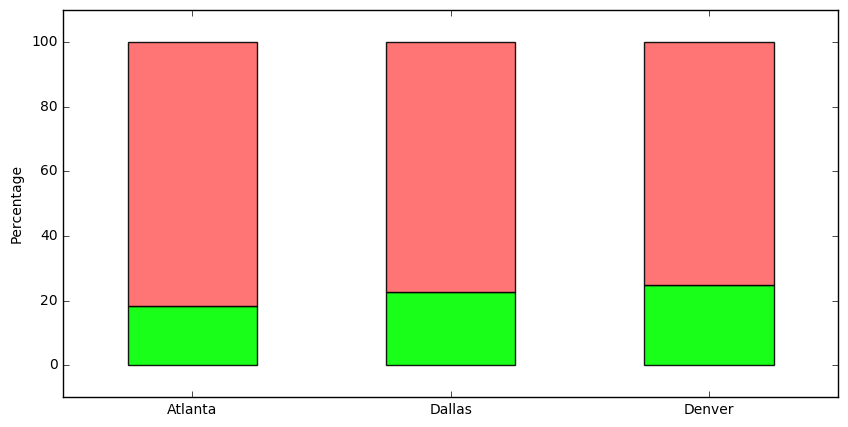

In [36]:

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 0.5

# positions of the left bar-boundaries
bar_l = [i for i in range(len(df['Accepted Predictions']))]

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l]

# Create the total score for each participant
totals = [i+j for i,j in zip(df['Accepted Predictions'], df['Closed Predictions'])]


# Create the percentage of the total score the pre_score value 
gained_rel = [i / j * 100 for  i,j in zip(df['Accepted Predictions'], totals)]

# Create the percentage of the total score the mid_score value
lost_rel = [i / j * 100 for  i,j in zip(df['Closed Predictions'], totals)]


# Create a bar chart in position bar_1
ax.bar(bar_l,
       # using pre_rel data
       gained_rel,
       # labeled
       label='Gained',
       # with alpha
       alpha=0.9,
       # with color
       color='#00ff00',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='black'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l,
       # using mid_rel data
       lost_rel,
       # with pre_rel
       bottom=gained_rel,
       # labeled
       label='Lost',
       # with alpha
       alpha=0.9,
       # with color
       color='#ff6666',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='black'
       )



market_labels = list(df.index)

# Set the ticks to be first names
plt.xticks(tick_pos, market_labels)
ax.set_ylabel("Percentage")
ax.set_xlabel("")

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='center')

# shot plot
plt.show()


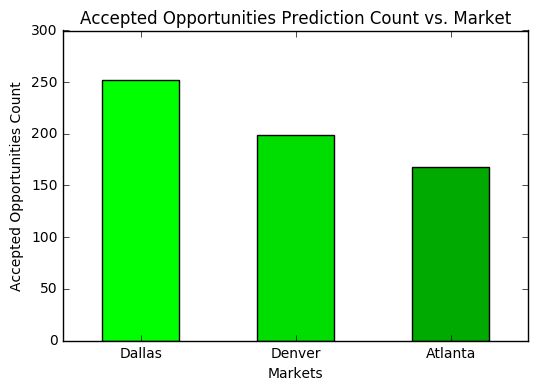

In [38]:
gained_market_counts[:10].plot(kind="bar", rot=0, color=['#00ff00', '#00dd00', '#00aa00'])
plt.title("Accepted Opportunities Prediction Count vs. Market")
plt.xlabel("Markets")
plt.ylabel("Accepted Opportunities Count")
plt.show()

# Prospective Profits per market

In [ ]:
denver_profit_series = positive_predict[positive_predict["Market"] == "Denver"]
atlanta_profit_series = positive_predict[positive_predict["Market"] == "Atlanta"]
dallas_profit_series = positive_predict[positive_predict["Market"] == "Dallas"]

denver_profit = np.sum(denver_profit_series["X36 NPV List"])
atlanta_profit = np.sum(atlanta_profit_series["X36 NPV List"])
dallas_profit = np.sum(dallas_profit_series["X36 NPV List"])

profits = {"Denver" : denver_profit, "Atlanta" : atlanta_profit, "Dallas" : dallas_profit}

profit_values = np.array(list(profits.values()))
profit_keys = np.array(list(profits.keys()))

indices = np.argsort(profit_values)[::-1]

colors = np.array(["#00ff00", "#00dd00", "#00bb00"])

plt.figure()
plt.title("Predicted Profit ($USD) vs. Market")
plt.xlabel("Markets")
plt.ylabel("Profit ($USD)")
plt.bar([0,1,2], profit_values[indices],
       color=colors, yerr=std[indices], align="center")

plt.xticks([0,1,2], profit_keys[indices], rotation='horizontal')
plt.xlim([-1, 3])
plt.show()

# Write to JSON

In [ ]:
positive_predict.to_json("../json/positive_predictions.json")
negative_predict.to_json("../json/negative_predictions.json")